# Kapoor, Rajan -- Homework 3

We study Table 13.2 on p 240 of Lange and Chapter 13 question 11 (on page 240) and Chapter 14, Example 14.10.1 on p246.

The table contains counts of the number of days a given number of deaths occurred. 

In [1]:
import numpy as np
freq = np.array([162,267,271,185,111,61,27,8,3,1])

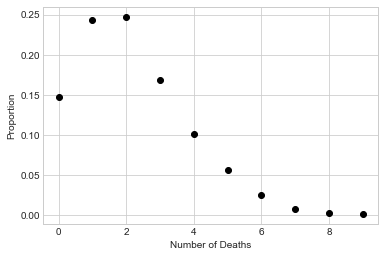

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## proportion of different number of deaths
plt.plot(np.arange(freq.size), freq/np.sum(freq), 'o', color='black')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");

## Problem 1

Confirm Lange's claim in question 11 that "A Poisson distribution gives a poor fit to these data . . ." by computing the MLE of the Poisson parameter $\lambda$ (this can be done by hand using calculus) and plotting the resulting probability mass function over the observed data. They should be a bit discrepant (thus justifying the claim).

## Solution

##### Case 1: Poisson distribution fit
Assuming the parameter lambda is constant, the likelihood is given by

\begin{align}
f &= \prod_{i=0}^{9}\left[e^{-\mu}\frac{\mu^{i}}{i!}\right]^{n_{i}}
\end{align}



Ignoring the terms independent of $\mu$, the log likelihood is given by
\begin{align}
\log f &= \sum_{i=0}^{9} n_i \left(-\mu + i\log \mu\right)
\end{align}

Setting 
\begin{align}
\frac{\partial \log f}{\partial \mu} &= 0
\end{align}
gives

\begin{align}
\mu &= \frac{\sum\limits_{i=0}^{9} n_{i}}{\sum_{i=0}^{9} i}
\end{align}

In [3]:
ni = freq
i = np.arange(10)

In [4]:
mu = np.sum(ni)/np.sum(i)
print(round(mu,4))

24.3556


In [5]:
import scipy.misc as smsc
# for factorial of nd arrays

In [6]:
i_fac = smsc.factorial(i)
poisd_mle = np.exp(-1/mu)*(1/mu)**i/i_fac
print(round(np.sum(poisd_mle),4))

1.0


##### Case 2 : Poisson Regression (aka log-linear model) fit with Newton's method  
(Code from class notes)

In [7]:
x = i
y = freq
def loglike(theta1,theta2,x,y):
    s = -np.exp(theta1 + x*theta2)
    return np.sum(s + (theta1 + theta2*x)*y)

def dloglike(theta1,theta2,x,y):
    s = -np.exp(theta1 + x*theta2)
    return np.array([np.sum(s + y),np.sum(x*s + x*y)])

def d2loglike(theta1,theta2,x,y):
    s = -np.exp(theta1 + x*theta2)
    cross = np.sum(s*x)
    return np.array([np.sum(s),cross,cross,np.sum(s*np.power(x,2))]).reshape(2,2)

In [8]:
theta1c = 0
theta2c = 0
Niter = 10
for jj in np.arange(Niter):
    print("theta1: " + str(theta1c) + " theta2: " + str(theta2c))
    g = dloglike(theta1c,theta2c,x,y).reshape((2,1))
    h = d2loglike(theta1c,theta2c,x,y)
    a,b = np.matmul(np.linalg.inv(h),g)
    c = 1.0
    half = True
    while half:
        t1 = theta1c - c*a
        t2 = theta2c - c*b
        if loglike(t1,t2,x,y) < loglike(theta1c,theta2c,x,y):
            print("halved")
            c = c / 2.0
        else:
            theta1c = t1
            theta2c = t2
            half = False

theta1: 0 theta2: 0
halved
halved
halved
halved
halved
theta1: [ 7.77102273] theta2: [-0.97272727]
theta1: [ 6.77999622] theta2: [-0.51401463]
theta1: [ 6.11509309] theta2: [-0.39620373]
theta1: [ 5.81996754] theta2: [-0.3411366]
theta1: [ 5.7762939] theta2: [-0.33364153]
theta1: [ 5.77545818] theta2: [-0.33350172]
theta1: [ 5.77545788] theta2: [-0.33350167]
theta1: [ 5.77545788] theta2: [-0.33350167]
theta1: [ 5.77545788] theta2: [-0.33350167]


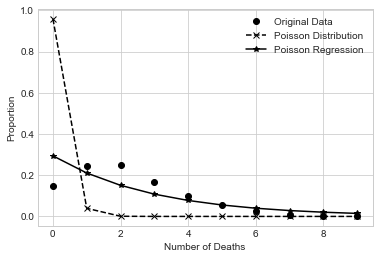

In [9]:
loglin_mle = np.exp(theta1c+theta2c*x)
loglin_mle = loglin_mle/sum(loglin_mle)

plt.plot(np.arange(freq.size), freq/np.sum(freq), 'o', color='black', label = 'Original Data')
plt.plot(i, poisd_mle,'x--', color='black',label='Poisson Distribution')
plt.plot(i, loglin_mle,'*-', color='black',label='Poisson Regression')
plt.legend()

plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");

## Problem 2

Fit the $\alpha$, $\mu_1$ and $\mu_2$ parameters for the mixture of two Poissons model proposed in Question 11. You must write your own fitting code (cannot use `scipy optimize` or R `optim`). You can write any sort of optimizer you like such as gradient ascent, Newton's method (or any of its varients), or an EM approach. Discuss how you select starting parameters and monitor convergence. You can confirm your results by also using Python or R built in optimizers.

## Solution
### Gradient Descent:

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
import numpy as np
import scipy.misc as smsc
# scipy for factorial of nd array
# the one in numpy cannot calculate factorial for an array
# np.math.factorial(deaths) gives TypeError
# import timeit
import time

In [12]:
deaths = np.arange(10)
deaths

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
freq = np.array([162, 267, 271, 185, 111, 61, 27, 8, 3, 1])
i = deaths
ni = freq

In [14]:
np.seterr(all='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

The likelihood function for mixture of two poissons is

\begin{align}
h &=\prod_{i=0}^{9}\left[\alpha e^{-\mu_1} \frac{\mu_{1}^{i}}{i!} + (1-\alpha) e^{-\mu_2} \frac{\mu_{2}^{i}}{i!}\right]^{n_i} &= \prod_{i=0}^{9}\left[\alpha u_i + (1-\alpha) v_i\right]^{n_i} &= \prod_{i=0}^{9}g_i^{n_i}
\end{align}

In [15]:
def u(mu, i, i_fac):
    return np.exp(-mu)*np.power(mu,i)/i_fac

def g(alpha, ui, vi):
    return alpha*ui + (1-alpha)*vi

The log-likelihood function $f$ is given by
\begin{align}
f = \log h = \sum_{i=0}^{9} n_i \log g_i
\end{align}

In [16]:
def f(ni, gi):
    return np.sum(ni*np.log(gi))

The partial derivative wrt $\alpha$ is given by
\begin{align}
\frac{\partial f}{\partial \alpha} &= \sum_{i=0}^{9} \frac{n_i}{g_i} (u_i-v_i)
\end{align}

In [17]:
def df_alpha(ni, gi, ui, vi):
    return np.sum(np.divide(ni,gi)*(ui-vi)) 
    # broadcasting for same sized arrays is elementwise numpy operation

The partial wrt $\mu_1$ is given by

\begin{align}
\frac{\partial f}{\partial \mu_1} &= \sum_{i=0}^{9} \frac{n_i}{g_i} \alpha u_i\left(\frac{i}{\mu_1}-1\right)
\end{align}

In [18]:
def df_mu1(alpha, ni, gi, ui, i, mu1):
    return alpha*np.sum(np.divide(ni,gi)*ui*(i/mu1 - 1))

The partial wrt $\mu_2$ is given by

\begin{align}
\frac{\partial f}{\partial \mu_2} &= \sum_{i=0}^{9} \frac{n_i}{g_i} (1-\alpha) v_i\left(\frac{i}{\mu_2}-1\right)
\end{align}

In [19]:
def df_mu2(alpha, ni, gi, vi, i, mu2):
    return (1-alpha)*np.sum(np.divide(ni,gi)*vi*(i/mu2 - 1))

Define function grad_ascent_update with following constraints on step size:

\begin{align}
f(x_{n+1}) > f(x_{n})\\
0 < \alpha < 1 \\
\mu_1 ,\mu_2 >0 \\
\end{align}

In [20]:
def grad_ascent_update(alpha0,mu10,mu20,i,i_fac,rate=1.0):
    
    ui0 = u(mu10, i, i_fac)
    vi0 = u(mu20, i, i_fac)
    gi0 = g(alpha0, ui0, vi0)
    
    alpha1 = alpha0 + rate*df_alpha(ni, gi0, ui0, vi0)   
    mu11 = mu10 + rate*df_mu1(alpha0, ni, gi0, ui0, i, mu10)
    mu21 = mu20 + rate*df_mu2(alpha0, ni, gi0, vi0, i, mu20)
    
    ui1 = u(mu11, i, i_fac)
    vi1 = u(mu21, i, i_fac)
    gi1 = g(alpha1, ui1, vi1)
    condition = True
    
    newlik = f(ni, gi1)
    if np.isnan(newlik):
        newlik = -np.inf
            
    while newlik < f(ni, gi0) or condition:
        rate = rate/2.0

        alpha1 = alpha0 + rate*df_alpha(ni, gi0, ui0, vi0)   
        mu11 = mu10 + rate*df_mu1(alpha0, ni, gi0, ui0, i, mu10)
        mu21 = mu20 + rate*df_mu2(alpha0, ni, gi0, vi0, i, mu20)
        
        ui1 = u(mu11, i, i_fac)
        vi1 = u(mu21, i, i_fac)
        gi1 = g(alpha1, ui1, vi1)
        
        newlik = f(ni, gi1)
        if np.isnan(newlik):
            newlik = -np.inf
        
        condition = alpha1 >= 1 or alpha1 <= 0 or mu11 <= 0 or mu21 <=0
        
    return [alpha1,mu11,mu21]

In [26]:
start_time = time.time()

alpha0,mu10,mu20 = 0.3,1.0,2.5
condition = True
loops = 1
max_iter = 1000
tolerance = 0.000001
val = [(alpha0,mu10,mu20)]
i_fac = smsc.factorial(i)

while condition and loops<max_iter: 
    [alpha1,mu11,mu21] = grad_ascent_update(alpha0,mu10,mu20,i,i_fac,rate=125.0)
    loops += 1
    diff = np.array([alpha1,mu11,mu21]) - np.array([alpha0,mu10,mu20])
    condition = np.sum(np.abs(diff)) >= tolerance
    [alpha0,mu10,mu20] = [alpha1,mu11,mu21]
    # print(f'alpha = {round(alpha0,4)}, mu1 = {round(mu10,4)}, mu2 = {round(mu20,4)}')
    val.append((alpha0,mu10,mu20))

end_time = time.time()

if loops == max_iter:
    print('Solution failed to converge. Try increasing rate or max iterations!')
else:
    print(f'Solution converged in {loops} iterations. Total time taken is {end_time-start_time:.4f}s.')

print('Result:')
print(f'alpha = {alpha0:.4f}, mu1 = {mu10:.4f}, mu2 = {mu20:.4f}')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: underflow encountered in exp
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Solution converged in 404 iterations. Total time taken is 0.4475s.
Result:
alpha = 0.3599, mu1 = 1.2561, mu2 = 2.6634


### Newton's Method:

The algebra for finding the Hessian seemed quite intensive for hand calculation. Here sympy package is used for calculation of the gradient and the Hessian functions. Define the symbols and expressions:

In [27]:
import sympy as sp
alpha, mu1, mu2, i, i_fac, ni = sp.symbols('alpha mu1 mu2 i i! n_i',real=True)  # define mathematical symbols
# symbolic expressions 
i_fac = sp.factorial(i)
u_expr = sp.exp(-mu1)*mu1**i/i_fac
v_expr = sp.exp(-mu2)*mu2**i/i_fac
g_expr = alpha*u_expr + (1-alpha)*v_expr
f_expr = ni*sp.log(g_expr)
f_expr

n_i*log(alpha*mu1**i*exp(-mu1)/factorial(i) + mu2**i*(-alpha + 1)*exp(-mu2)/factorial(i))

For pretty printing:

In [28]:
from sympy import init_printing
init_printing(use_latex='mathjax',fontsize = '10pt')

In [29]:
f_expr

      ⎛    i  -μ₁     i           -μ₂⎞
      ⎜α⋅μ₁ ⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ   ⎟
nᵢ⋅log⎜────────── + ─────────────────⎟
      ⎝    i!               i!       ⎠

Find expressions for summands of the gradient and the hessian:

In [30]:
from sympy.tensor.array import derive_by_array

In [31]:
gradf_expr = derive_by_array(f_expr, (alpha, mu1, mu2))
gradf_expr

⎡      ⎛  i  -μ₁     i  -μ₂⎞        ⎛      i  -μ₁       i  -μ₁⎞     ⎛    i    
⎢      ⎜μ₁ ⋅ℯ      μ₂ ⋅ℯ   ⎟        ⎜α⋅i⋅μ₁ ⋅ℯ      α⋅μ₁ ⋅ℯ   ⎟     ⎜i⋅μ₂ ⋅(-α
⎢   nᵢ⋅⎜──────── - ────────⎟     nᵢ⋅⎜──────────── - ──────────⎟  nᵢ⋅⎜─────────
⎢      ⎝   i!         i!   ⎠        ⎝   μ₁⋅i!           i!    ⎠     ⎝       μ₂
⎢──────────────────────────────  ──────────────────────────────  ─────────────
⎢    i  -μ₁     i           -μ₂      i  -μ₁     i           -μ₂             i 
⎢α⋅μ₁ ⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ     α⋅μ₁ ⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ            α⋅μ₁ ⋅
⎢────────── + ─────────────────  ────────── + ─────────────────         ──────
⎣    i!               i!             i!               i!                    i!

       -μ₂     i           -μ₂⎞⎤
 + 1)⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ   ⎟⎥
────────── - ─────────────────⎟⎥
⋅i!                  i!       ⎠⎥
───────────────────────────────⎥
 -μ₁     i           -μ₂       ⎥
ℯ      μ₂ ⋅(-α + 1)⋅ℯ          ⎥
──── + ─────────────────       ⎥
               i!       

Increase size by right click -> Math Settings -> Scale all Math : 150%. 

Clearly the above expression is same as the summand of the gradient calculated by hand for Gradient Descent above (note that the denominator is gi).

In [32]:
hessianf_expr = derive_by_array(gradf_expr, (alpha, mu1, mu2))

The summands of

$$\left[\frac{\partial^{2} f}{\partial \alpha^{2}}, \frac{\partial^{2} f}{\partial \mu_1 \partial \alpha}, \frac{\partial^{2} f}{\partial \mu_2 \partial \alpha}\right] $$

are given by the first column of the hessian matrix

In [33]:
hessianf_expr[0],hessianf_expr[3],hessianf_expr[6]

⎛   ⎛    i  -μ₁     i  -μ₂⎞ ⎛  i  -μ₁     i  -μ₂⎞     ⎛  i  -μ₁     i  -μ₂⎞ ⎛ 
⎜   ⎜  μ₁ ⋅ℯ      μ₂ ⋅ℯ   ⎟ ⎜μ₁ ⋅ℯ      μ₂ ⋅ℯ   ⎟     ⎜μ₁ ⋅ℯ      μ₂ ⋅ℯ   ⎟ ⎜ 
⎜nᵢ⋅⎜- ──────── + ────────⎟⋅⎜──────── - ────────⎟  nᵢ⋅⎜──────── - ────────⎟⋅⎜-
⎜   ⎝     i!         i!   ⎠ ⎝   i!         i!   ⎠     ⎝   i!         i!   ⎠ ⎝ 
⎜────────────────────────────────────────────────, ───────────────────────────
⎜                                       2                                     
⎜       ⎛    i  -μ₁     i           -μ₂⎞                     ⎛    i  -μ₁     i
⎜       ⎜α⋅μ₁ ⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ   ⎟                     ⎜α⋅μ₁ ⋅ℯ      μ₂ 
⎜       ⎜────────── + ─────────────────⎟                     ⎜────────── + ───
⎝       ⎝    i!               i!       ⎠                     ⎝    i!          

       i  -μ₁       i  -μ₁⎞        ⎛    i  -μ₁     i  -μ₁⎞       ⎛  i  -μ₁    
 α⋅i⋅μ₁ ⋅ℯ      α⋅μ₁ ⋅ℯ   ⎟        ⎜i⋅μ₁ ⋅ℯ      μ₁ ⋅ℯ   ⎟       ⎜μ₁ ⋅ℯ      μ
 ──────────── + ──────────⎟     nᵢ⋅⎜────────── - ──

which can be simplified for 'hard-coding' to:

In [34]:
[sp.simplify(hessianf_expr[0]),sp.simplify(hessianf_expr[3]),sp.simplify(hessianf_expr[6])]

⎡                         2                                                   
⎢      ⎛  i  μ₂     i  μ₁⎞          ⎛    i     i + 1⎞ ⎛    i  μ₂     ⎛  i  μ₂ 
⎢  -nᵢ⋅⎝μ₁ ⋅ℯ   - μ₂ ⋅ℯ  ⎠       nᵢ⋅⎝i⋅μ₁  - μ₁     ⎠⋅⎝α⋅μ₁ ⋅ℯ   - α⋅⎝μ₁ ⋅ℯ   
⎢──────────────────────────────, ─────────────────────────────────────────────
⎢                             2                                               
⎢⎛    i  μ₂     i          μ₁⎞                            ⎛    i  μ₂     i    
⎣⎝α⋅μ₁ ⋅ℯ   - μ₂ ⋅(α - 1)⋅ℯ  ⎠                         μ₁⋅⎝α⋅μ₁ ⋅ℯ   - μ₂ ⋅(α 

                                                                              
    i  μ₁⎞     i          μ₁⎞  μ₂     ⎛    i     i + 1⎞ ⎛      i  μ₂     i    
- μ₂ ⋅ℯ  ⎠ - μ₂ ⋅(α - 1)⋅ℯ  ⎠⋅ℯ    nᵢ⋅⎝i⋅μ₂  - μ₂     ⎠⋅⎝- α⋅μ₁ ⋅ℯ   + μ₂ ⋅(α 
─────────────────────────────────, ───────────────────────────────────────────
         2                                                                    
      μ₁⎞                                          

'Hard coding' even this expression is considerable effort and prone to errors. Instead the sympy expressions for  the gradient and hessian as sums functions of only $\alpha$, $\mu_1$ and $\mu_2$ are calculated and converted to numpy functions.

Code from: https://stackoverflow.com/questions/26402387/sympy-summation-with-indexed-variable

In [35]:
s = sp.Sum(sp.Indexed('x',i),(i,0,9))
s.doit()

x[0] + x[1] + x[2] + x[3] + x[4] + x[5] + x[6] + x[7] + x[8] + x[9]

In [36]:
[s.function.subs(s.variables[0], j)
... for j in range(s.limits[0][1], s.limits[0][2] + 1)]

[x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9]]

In [37]:
test = [12, 10, 20, 10, 22, 21, 33, 12, 32, 11]
np.sum(np.array(test))

183

In [38]:
sp.Subs(s, [s.function.subs(s.variables[0], j)
            for j in range(s.limits[0][1], s.limits[0][2] + 1)], test)

⎛  9       ⎞│                                                                 
⎜ ___      ⎟│                                                                 
⎜ ╲        ⎟│                                                                 
⎜  ╲   x[i]⎟│                                                                 
⎜  ╱       ⎟│                                                                 
⎜ ╱        ⎟│                                                                 
⎜ ‾‾‾      ⎟│                                                                 
⎝i = 0     ⎠│x[0]=12, x[1]=10, x[2]=20, x[3]=10, x[4]=22, x[5]=21, x[6]=33, x[

                       
                       
                       
                       
                       
                       
                       
7]=12, x[8]=32, x[9]=11

In [39]:
num_vars = 3

In [40]:
sp.Subs(s, [s.function.subs(s.variables[0], j)
            for j in range(s.limits[0][1], s.limits[0][2] + 1)], test).doit()

183

Define function for finding the expression of a sum:

In [41]:
find_sum = lambda x: sp.Subs(s, [s.function.subs(s.variables[0], j)
                          for j in range(s.limits[0][1], s.limits[0][2] + 1)], x).doit()

Find expressions of log-likelihood, gradient and hessians and substitute values of i and ni: (The outer find_sum( ) is for summation expression of list comprehension result on f_expr.subs( ) )

In [42]:
loglhood_expr = find_sum([f_expr.subs([(ni,freq[j]),(i,deaths[j])]) for j in range (10)] )
loglhood_expr

                                                                              
       ⎛   -μ₁             -μ₂⎞          ⎛      -μ₁                -μ₂⎞       
162⋅log⎝α⋅ℯ    + (-α + 1)⋅ℯ   ⎠ + 267⋅log⎝α⋅μ₁⋅ℯ    + μ₂⋅(-α + 1)⋅ℯ   ⎠ + 271⋅
                                                                              

   ⎛    2  -μ₁     2           -μ₂⎞          ⎛    3  -μ₁     3           -μ₂⎞ 
   ⎜α⋅μ₁ ⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ   ⎟          ⎜α⋅μ₁ ⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ   ⎟ 
log⎜────────── + ─────────────────⎟ + 185⋅log⎜────────── + ─────────────────⎟ 
   ⎝    2                2        ⎠          ⎝    6                6        ⎠ 

         ⎛    4  -μ₁     4           -μ₂⎞         ⎛    5  -μ₁     5           
         ⎜α⋅μ₁ ⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ   ⎟         ⎜α⋅μ₁ ⋅ℯ      μ₂ ⋅(-α + 1)⋅ℯ
+ 111⋅log⎜────────── + ─────────────────⎟ + 61⋅log⎜────────── + ──────────────
         ⎝    24               24       ⎠         ⎝   120              120    

-μ₂⎞         ⎛    6  -μ₁     6           -μ₂⎞    

Substitute values of i and ni. For gradient (hessian) each entry in the vector (matrix) is a sum. For each entry, each summand has different value of i and ni. Hence the double loop in list comprehension.

In [43]:
grad_expr = [find_sum([gradf_expr[k].subs([(ni,freq[j]),(i,deaths[j])])
                for j in range (10)])
             for k in range(num_vars)]

In [44]:
hessian_expr = [find_sum([hessianf_expr[k].subs([(ni,freq[j]),(i,deaths[j])])
                   for j in range (10)])
                for k in range(num_vars**2)]

Convert the sympy expressions for log-likelihood to numpy functions:

In [45]:
loglhood = sp.lambdify([alpha, mu1, mu2], loglhood_expr,"numpy")
?loglhood

In [46]:
grad = sp.lambdify([alpha, mu1, mu2], grad_expr,"numpy")

In [47]:
hessian = sp.lambdify([alpha, mu1, mu2], hessian_expr,"numpy")

Define function to check if the negative of Hessian is positive definite:

In [48]:
def is_pos_def_cholesky(A):
    #return np.all(np.linalg.eigvals(A) > 0)
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [49]:
def is_pos_def(A):
    return np.all(np.linalg.eigvals(A) > 0)

Define the Newton's update method:

#### Some Comments:

* By definition, the condition number of a matrix is the product of norms of matrix and its inverse. It is equal to the ratio of largest and smallest eigen value. Used here for checking hessian singularity before taking inverse: <br>
np.linalg.cond(neg_hessian_val) < 1/sys.float_info.epsilon <br>
https://stackoverflow.com/questions/13249108/efficient-pythonic-check-for-singular-matrix


* If negative hessian is not a positive definite matrix, add abs(minimum eigen value + $\epsilon$) \* Identity matrix. <br>
min_eigval = np.min(np.linalg.eigvals(neg_hessian_val)) <br>
E = (abs(min_eigval)+0.12)\*np.eye(3) <br>
neg_hessian_val = neg_hessian_val + E <br>
http://www.math.mtu.edu/~msgocken/ma5630spring2003/lectures/global1/global1/node4.html <br>
Also discussed here: Hessian modification technique such as "adding a multiple of the identity": <br>
https://math.stackexchange.com/questions/1130002/newton-optimization-algorithm-with-non-positive-definite-hessian

* Check conditions for alpha and mu: <br>
condition = alpha1 >= 1 or alpha1 <= 0 or mu11 <= 0 or mu21 <=0

* Check if loglikelihood is NaN and if so set it to Inf <br>
if np.isnan(newlik):
    newlik = -np.inf

In [50]:
import sys

def newton_update3(x0,rate=1.0):
    """Generates next step based on Newton's Method."""
    alpha0,mu10,mu20 = x0
    grad_val = np.array(grad(alpha0, mu10, mu20))[:,np.newaxis]
    
    if np.any(np.isnan(hessian(alpha0, mu10, mu20))):
                raise ValueError('Hessian has nan values.')
    else:
        neg_hessian_val = -np.array(hessian(alpha0, mu10, mu20)).reshape(3,3)
    
    if np.linalg.cond(neg_hessian_val) < 1/sys.float_info.epsilon:
    
        if is_pos_def_cholesky(neg_hessian_val):
            min_eigval = np.min(np.linalg.eigvals(neg_hessian_val))
            E = (abs(min_eigval)+0.12)*np.eye(3)
            neg_hessian_val = neg_hessian_val + E
            
        hessinv = np.linalg.inv(neg_hessian_val)
        prod = np.matmul(hessinv,grad_val)
            
        x1 = x0[:,np.newaxis] + rate*prod
        alpha1,mu11,mu21 = x1
        newlik = loglhood(alpha1,mu11,mu21)
        if(np.isnan(newlik)):
                newlik = -np.inf

        condition = True
        
        while newlik < loglhood(alpha0,mu10,mu20) or condition:
            rate = rate/2.0
            x1 = x0[:,np.newaxis] + rate*prod
            alpha1,mu11,mu21 = x1
            newlik = loglhood(alpha1,mu11,mu21)
            if np.isnan(newlik):
                newlik = -np.inf
            #print(x1,y1)
            condition = alpha1 >= 1 or alpha1 <= 0 or mu11 <= 0 or mu21 <=0
        return x1.flatten()
    else:
        raise ValueError('Hessian is singular.')
    

In [58]:
import time
start_time = time.time()

x0 = np.array([0.3,1.0,2.5])
condition = True
loops = 1
max_iter = 200
tolerance = 0.000001
valNewton = [x0]

while condition and loops<max_iter: 
    x1 = newton_update3(x0,rate=1.0)
    loops += 1
    condition = np.sum(np.abs(x0-x1)) >= tolerance
    x0 = x1
    valNewton.append(x0)

end_time = time.time()

if loops == max_iter:
    print('Solution failed to converge. Try increasing rate or max iterations!')
else:
    print(f'Solution converged in {loops} iterations. Total time taken is {end_time-start_time:.4}s.')

print('Result:')
print(f'alpha = {x0[0]:.4}, mu1 = {x0[1]:.4}, mu2 = {x0[2]:.4}')

Solution converged in 37 iterations. Total time taken is 0.2592s.
Result:
alpha = 0.3599, mu1 = 1.256, mu2 = 2.663


Result from using is_pos_def() instead of is_pos_def_cholesky():

Solution converged in 43 iterations. Total time taken is 0.3055s.

Result:
alpha = 0.3599, mu1 = 1.2561, mu2 = 2.6634

##### Observe convergence in 3D plot:

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

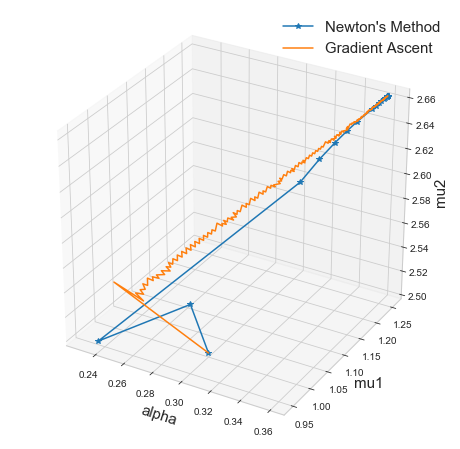

In [60]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 15

fig = plt.figure(figsize=(8,8))

ax = fig.gca(projection='3d')

Alpha = [tup[0] for tup in val]
Mu1 = [tup[1] for tup in val]
Mu2 = [tup[2] for tup in val]

AlphaN = [tup[0] for tup in valNewton]
Mu1N = [tup[1] for tup in valNewton]
Mu2N = [tup[2] for tup in valNewton]

ax.plot(AlphaN, Mu1N, Mu2N, '*-', label="Newton's Method")
ax.plot(Alpha, Mu1, Mu2, '-',label='Gradient Ascent')
ax.legend()

ax.set_xlabel('alpha', fontsize=15)
ax.set_ylabel('mu1', fontsize=15)
ax.set_zlabel('mu2', fontsize=15, rotation = 90)

#ax.set_xlim3d(0,1)

plt.show()

##### Check if the mixture model is a good fit:

In [61]:
i, ni = deaths, freq
i_fac = smsc.factorial(i)
alpha0, mu10, mu20 = [0.35987258442400516, 1.2560722507101618, 2.6633886707631791]
pois_mle = (alpha0*np.exp(-mu10)*mu10**i+(1-alpha0)*np.exp(-mu20)*mu20**i)/i_fac
print(f'{np.sum(pois_mle):.4}')

0.9997


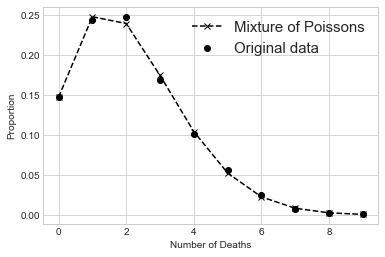

In [63]:
plt.plot(i, pois_mle,'x--', color='black',label='Mixture of Poissons')
plt.plot(np.arange(freq.size), freq/np.sum(freq), 'o', color='black',label='Original data')
plt.legend()
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");